## K-means Clustering
**(With extracts from the Nicolas Vandepu's book "Data Science for Supply Chain Forecasting")**

K-means clustering is a widely utilized unsupervised learning technique in data science for classifying unlabeled data into groups based on their features, not pre-defined categories. The method involves partitioning data points into 'k' distinct non-overlapping subgroups or clusters. The number 'k' represents the number of clusters to be created, which is a parameter defined by the user. The main goal of K-means is to minimize the sum of the squared distances between the data points and their respective cluster centroid, which is the center of mass for each cluster. This algorithm is typically the first choice for practitioners to get an understanding of the dataset's structure due to its simplicity and effectiveness in revealing patterns and regularities within the data.

In [1]:
import pandas as pd

# Define the import_data function
def import_data():
    data = pd.read_csv(file_path)
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df = pd.pivot_table(data=data, values=['Quantity'], index='Make', columns='Period', aggfunc='sum', fill_value=0)
    return df

# URL of the CSV file
file_path = "https://supchains.com/wp-content/uploads/2021/07/norway_new_car_sales_by_make1.csv"

# Create the DataFrame using the import_data function
df = import_data()

# Now 'df' contains the data from the provided URL in the desired format.

# Print the DataFrame
print(df.head())

             Quantity                                                          \
Period        2007-01 2007-02 2007-03 2007-04 2007-05 2007-06 2007-07 2007-08   
Make                                                                            
Alfa Romeo         16       9      21      20      17      21      14      12   
Aston Martin        0       0       1       0       4       3       3       0   
Audi              599     498     682     556     630     498     562     590   
BMW               352     335     365     360     431     477     403     348   
Bentley             0       0       0       0       0       1       0       0   

                              ...                                          \
Period       2007-09 2007-10  ... 2016-04 2016-05 2016-06 2016-07 2016-08   
Make                          ...                                           
Alfa Romeo        15      10  ...       3       1       2       1       6   
Aston Martin       0       0  ...       0  

## Looking for Meaningful Centers
 
We just learned a compelling and automated way to label an entire dataset, thanks to machine learning. But how can we apply this to our historical demand? 
The question you should ask yourself is: what are the features I want to categorize my products on? Depending on each dataset, you might prefer different approaches. Here are some ideas: 
               
- **Volume:**
We can obviously start categorizing products based on their sales volume. Most likely, this categorization won’t provide so much added value, as you could just do a good old Pareto Classification to get a similar result. 
- **Additive Seasonality:**
If we cluster the products based on their additive seasonality factors, we will cluster them based on their average volume and their seasonality. You might then end up with groups containing just a few products. 
- **Multiplicative Seasonality:** 
If we take the multiplicative seasonal factors, our products will then be categorized only based on their seasonal behavior—irrespective of their absolute size. This sounds much better.

### Scaling
The K-means algorithm is very sensitive to extreme values (that, by definition, are far away from any other values) so that we will have to normalize all the seasonal factors. It means that each product’s seasonal factors will be reduced to have a mean of 0 and a range of 1.

K-means is very sensitive to scaling; always remember to scale your dataset before applying this technique. As we did here, it is always a best practice to visualize your results to check that they are meaningful. Another good check is to count the number of products in each cluster: if you obtain some clusters with only a few items, that might be a clue that the clusters are not meaningful.

####  Compute the (multiplicative) seasonal factors
In order to do so, we will create a function seasonal_factors() that will return the seasonal factors based on a historical demand dataset.

In [2]:
def seasonal_factors(df, slen):
    # Create a new DataFrame 's' with the same index as 'df' to store the seasonal factors
    s = pd.DataFrame(index=df.index)
    
    # Loop over the range of seasonal length 'slen' to calculate mean values
    # for each season across all columns
    for i in range(slen):
        # Calculate the mean of every 'slen' elements in each column and assign it
        # to a new column in DataFrame 's'. This mean is a seasonal factor.
        # 'i::slen' is a slicing technique that starts at index 'i' and skips 'slen' elements at a time.
        s[i+1] = df.iloc[:, i::slen].mean(axis=1)
    
    # Normalize each column in 's' by dividing by the mean of the column to get the relative seasonal factors
    # Then, replace any missing values resulted from division by zero with 0.
    s = s.divide(s.mean(axis=1), axis=0).fillna(0)
    
    # Return the DataFrame containing seasonal factors for each season
    return s

#### Create a scaler() function 
It will return the seasonality factors scaled with a range of 1 and a mean of 0.

In [3]:
def scaler(s):
    # Calculate the mean of each row
    mean = s.mean(axis=1)
    
    # Find the maximum value in each row
    maxi = s.max(axis=1)
    
    # Find the minimum value in each row
    mini = s.min(axis=1)
    
    # Subtract the mean from each element in the DataFrame (broadcasting along rows)
    s = s.subtract(mean, axis=0)
    
    # Perform element-wise division of the DataFrame by the range (max - min)
    # Broadcasting along rows. If the range is zero, 'fillna(0)' handles division by zero by replacing NaNs with 0.
    s = s.divide(maxi-mini, axis=0).fillna(0)
    
    # Return the scaled DataFrame
    return s

We can now use both our functions to populate scaled seasonal factors:

In [4]:
df = import_data()

s = seasonal_factors(df,slen=12)
s= scaler(s)
print(s.head())

                    1         2         3         4         5         6   \
Make                                                                       
Alfa Romeo    0.415094 -0.066895  0.536878 -0.293310  0.018010 -0.095197   
Aston Martin -0.308333 -0.299242  0.100758  0.400758  0.500758  0.600758   
Audi         -0.454203 -0.373367 -0.080042  0.545797  0.283014 -0.036244   
BMW           0.244091 -0.259060 -0.057379  0.058692 -0.000657 -0.072610   
Bentley      -0.055556  0.308081 -0.025253 -0.358586 -0.358586  0.641414   

                    7         8         9         10        11        12  
Make                                                                      
Alfa Romeo    0.348199  0.329331 -0.132933 -0.349914 -0.463122 -0.246141  
Aston Martin  0.200758 -0.299242  0.100758 -0.399242 -0.199242 -0.399242  
Audi          0.449558  0.182165 -0.380859  0.000061 -0.115771 -0.020109  
BMW          -0.513262 -0.131434  0.007222  0.344932  0.486738 -0.107274  
Bentley      -0.0

#### Cluster Definition
 
Let’s now use the K-means algorithm implementation from scikit-learn to identify the different clusters among our products (we assume df to contain the historical demand per product).6 We will use the function KMeans() that takes as an input the number of  clusters we want (n_clusters).

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(s)
df['Group'] = kmeans.predict(s)

**Note:** Giving a specific random_state to KMeans is rather helpful, as we can expect the same clusters each time we call the algorithm (as long as the historical values provided do not change). This will make our analyst life much easier (you can actually give a random_state to most of the scikit-learn models).

## Experimentation
### Inertia
 
Let’s define the inertia of a K-means model as the sum of all the distances between each data sample and its associated cluster center. The lower the inertia, the more “accurate” the model. Reducing the inertia of such a model is very easy: just add more clusters!, the more clusters, the lower the inertia (until every data sample has its own center).

<Axes: xlabel='Number of clusters'>

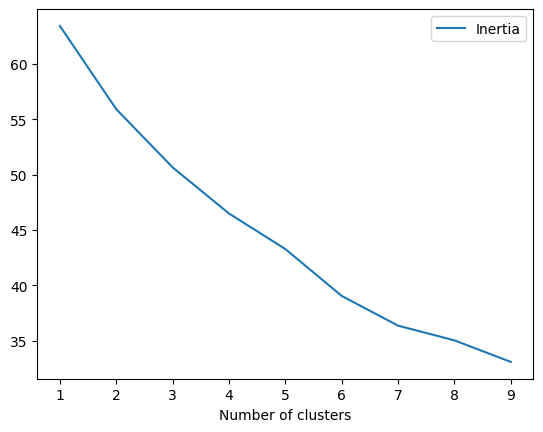

In [6]:
# Initialize an empty list to store the results
results = []

# Loop over a range of numbers to determine the optimal number of clusters
for n in range(1, 10):
    # Instantiate the KMeans algorithm with 'n' clusters and a fixed random state
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=0).fit(s)
    
    # Append the number of clusters 'n' and the corresponding inertia to the results list
    # Inertia is a measure of how internally coherent clusters are (lower is better)
    results.append([n, kmeans.inertia_])

# Convert the results list into a pandas DataFrame
# This DataFrame has two columns: 'Number of clusters' and 'Inertia'
results = pd.DataFrame(data=results, columns=['Number of clusters', 'Inertia'])

# Set the 'Number of clusters' column as the index of the DataFrame
results = results.set_index('Number of clusters')

# Plot the inertia values for each number of clusters
# This plot helps to determine the optimal number of clusters using the elbow method
results.plot()

**Note:** More clusters will result in lower inertia (i. e., smaller and denser clusters), but these clusters might also get less meaningful and come with a higher risk of overfitting

###  Cluster Visualization
Let's create a DataFrame to view the centers of the clusters determined by the KMeans algorithm. After transposing the DataFrame, each row corresponds to a cluster center, and the index is set to the abbreviations of the months from the calendar module, as there is a monthly seasonal cycle represented in the data s. The columns are then named to reflect the cluster number for easy reference.

In [7]:
# Import the calendar module to access month abbreviations
import calendar

# Instantiate and fit the KMeans model with 4 clusters and a random state of 0 for reproducibility
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(s)

# Create a DataFrame from the cluster centers obtained from the fitted KMeans model
# and transpose the DataFrame so that the cluster centers are in the columns
centers = pd.DataFrame(data=kmeans.cluster_centers_).transpose()

# Set the index of the DataFrame to month abbreviations (ignoring the first empty element from calendar.month_abbr)
centers.index = calendar.month_abbr[1:]

# Rename the columns to 'Cluster x' where x is the cluster number (0 to number of clusters - 1)
centers.columns = [f'Cluster {x}' for x in range(centers.shape[1])]

#### Create a heatmap to visualize the cluster centers
Where the cluster centers are visualized with annotations showing the value of each center to two decimal places. The diverging color map 'RdBu_r' is used to easily distinguish high and low values relative to the center value of 0.

- **annot=True** annotates each cell with the numeric value using the string format 'fmt'

- **fmt='.2f'** formats the annotated value to two decimal places

- **center=0** sets the center of the colormap at value 0

- **cmap='RdBu_r'** sets the colormap to a diverging red to blue color palette

<Axes: >

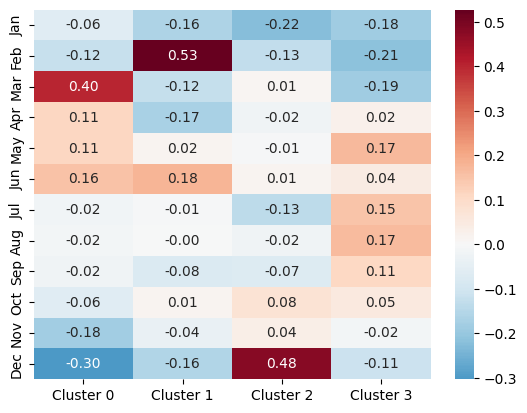

In [8]:
# Import seaborn, which is a Python data visualization library based on matplotlib
import seaborn as sns

sns.heatmap(centers, annot=True, fmt='.2f', center=0, cmap='RdBu_r')

### Number of Products per Cluster 
We can also count the number of products inside each cluster to understand whether these are meaningful.

- **value_counts()** counts the number of occurrences of each unique value in the 'Group' column.

- **sort_index()** sorts these counts based on the index, which corresponds to the group number in this case.

The sorted counts are then printed to the console.

This code is useful for understanding the distribution of data points across the different clusters identified by the 'Group' column. By sorting on the index, the counts are displayed in order of the group number.

In [9]:
print(df['Group'].value_counts().sort_index())

Group
0    19
1     9
2    15
3    22
Name: count, dtype: int64
